In [78]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from mongo_wrapper.mongo_wrapper import MongoWrapper

import os
from dotenv import load_dotenv

import warnings
warnings.filterwarnings("ignore")

In [79]:
load_dotenv()

True

In [80]:
MONGO_IP = os.getenv("MONGO_IP")
MONGO_PORT = os.getenv("MONGO_PORT")
MONGO_DB = "serpapi_5y"
MONGO_USERNAME = os.getenv("MONGO_USERNAME")
MONGO_PASSWORD = os.getenv("MONGO_PASSWORD")
SERPAPI_API_KEY = os.getenv("SERPAPI_API_KEY")

In [81]:
STATES = [
    "MX-AGU",
    "MX-BCN",
    "MX-BCS",
    "MX-CAM",
    "MX-CHP",
    "MX-CHH",
    "MX-COA",
    "MX-COL",
    "MX-DUR",
    "MX-GUA",
    "MX-GRO",
    "MX-HID",
    "MX-JAL",
    "MX-DIF",
    "MX-MIC",
    "MX-MOR",
    "MX-NAY",
    "MX-NLE",
    "MX-OAX",
    "MX-PUE",
    "MX-QUE",
    "MX-ROO",
    "MX-SLP",
    "MX-SIN",
    "MX-SON",
    "MX-MEX",
    "MX-TAB",
    "MX-TAM",
    "MX-TLA",
    "MX-VER",
    "MX-YUC",
    "MX-ZAC"
]

In [82]:
mongo_client = MongoWrapper(
    db=MONGO_DB,
    user=MONGO_USERNAME,
    password=MONGO_PASSWORD,
    ip=MONGO_IP,
    port=MONGO_PORT
)

2025-05-28 13:00:59,582 INFO Connected to serpapi_5y database on 206.81.16.39


In [83]:
def filter_geo_data(data: list) -> None:
    result = {}

    for search in data:
        search_data = search["compared_breakdown_by_region"]

        for region in search_data:
            for keyword_value in region["values"]:
                if keyword_value["query"] not in result:
                    result[keyword_value["query"]] = {}
                
                result[keyword_value["query"]][region["location"]] = keyword_value["extracted_value"]

    return result

In [84]:
keywords = [
    "crisis,desempleo,pobreza,conflictos,discriminación",
    "violencia,becas,escuela secundaria,enfermedad,centro de salud",
    "pensiones,seguro social,ayuda alimentaria,banco de alimentos,comedor comunitario",
    "comida barata,receta pobre,apoyo Infonavit,ayuda renta,renta barata",
    "servicios en la vivienda,vivienda del gobierno"
]

geo_data = []

for index, keyword_set in enumerate(keywords):
    gt_data = mongo_client.get_collection_entries(collection=f'serpapi_geo_{keyword_set}')[0]

    geo_data.append(gt_data)

geo_data = filter_geo_data(geo_data)


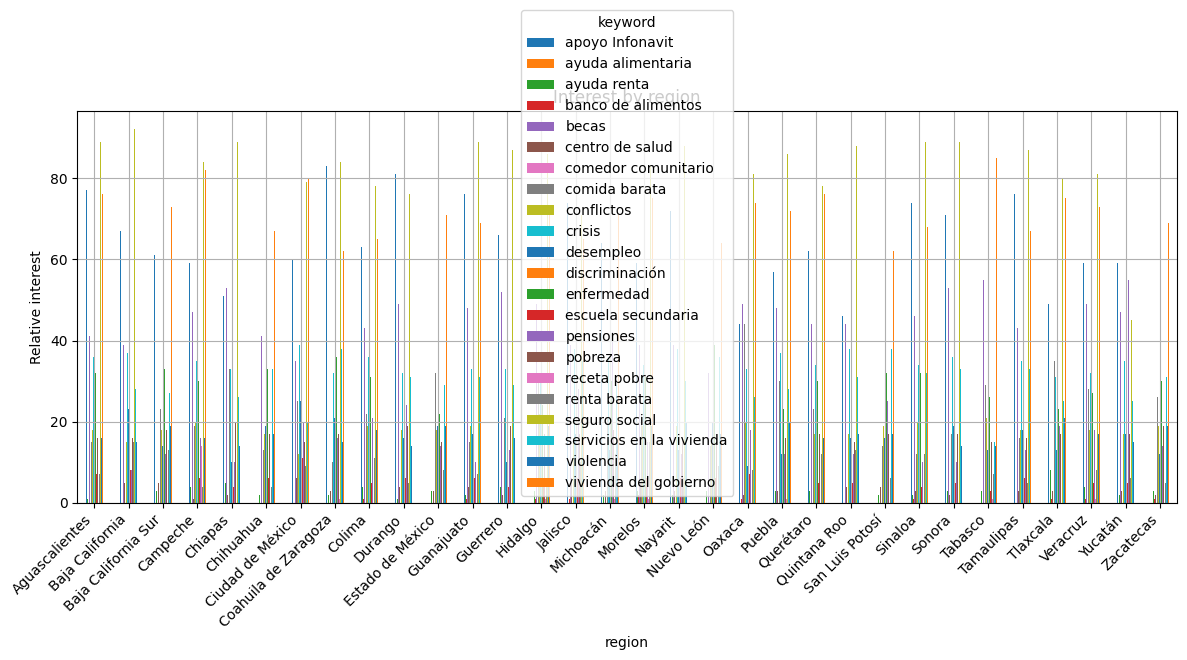

In [85]:
def plot_interest_by_region(data: dict):
    rows = []
    for kw, region_dict in data.items():
        for region, val in region_dict.items():
            rows.append({"keyword": kw, "region": region, "value": val})

    data = pd.DataFrame(rows)

    pivot = (data
            .pivot(index="region", columns="keyword", values="value")
            .fillna(0))

    pivot.plot(kind="bar", figsize=(12, 6))
    plt.grid(True)
    plt.ylabel("Relative interest")
    plt.xticks(rotation=45, ha="right")
    plt.title("Interest by region")
    plt.tight_layout()
    plt.show()

plot_interest_by_region(geo_data)

In [86]:
def plot_one_keyword(data: dict, keyword: str) -> None:
    rows = []
    for kw, region_dict in data.items():
        for region, val in region_dict.items():
            rows.append({"keyword": kw, "region": region, "value": val})

    data = pd.DataFrame(rows)

    d = (
        data[data["keyword"] == keyword]
        .sort_values("value", ascending=False)
    )

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(d["region"], d["value"], color="pink", alpha=0.5)

    for bar in bars:
        width = bar.get_width()
        ax.text(
            width + 0.4,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.0f}",
            va="center",
            fontsize=9,
        )

    ax.invert_yaxis() 
    ax.set_xlabel("Relative interest")
    ax.set_title(f'{keyword} interest by region')

    ax.grid(True)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_xlim(0, d["value"].max() * 1.15)

    plt.tight_layout()
    plt.show()


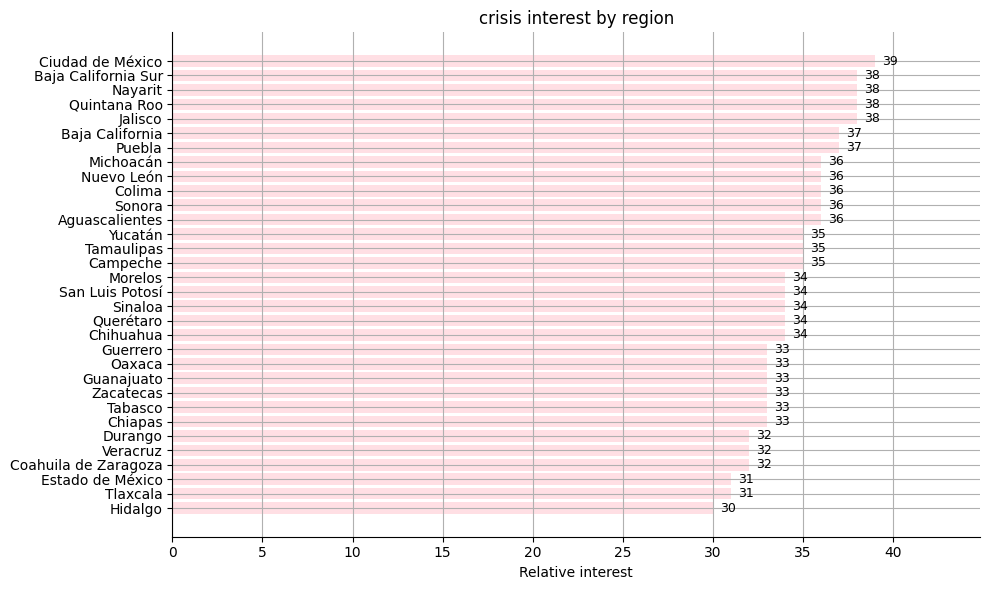

In [87]:
plot_one_keyword(geo_data, "crisis")

In [88]:
mx_states = gpd.read_file("files/states.geojson")

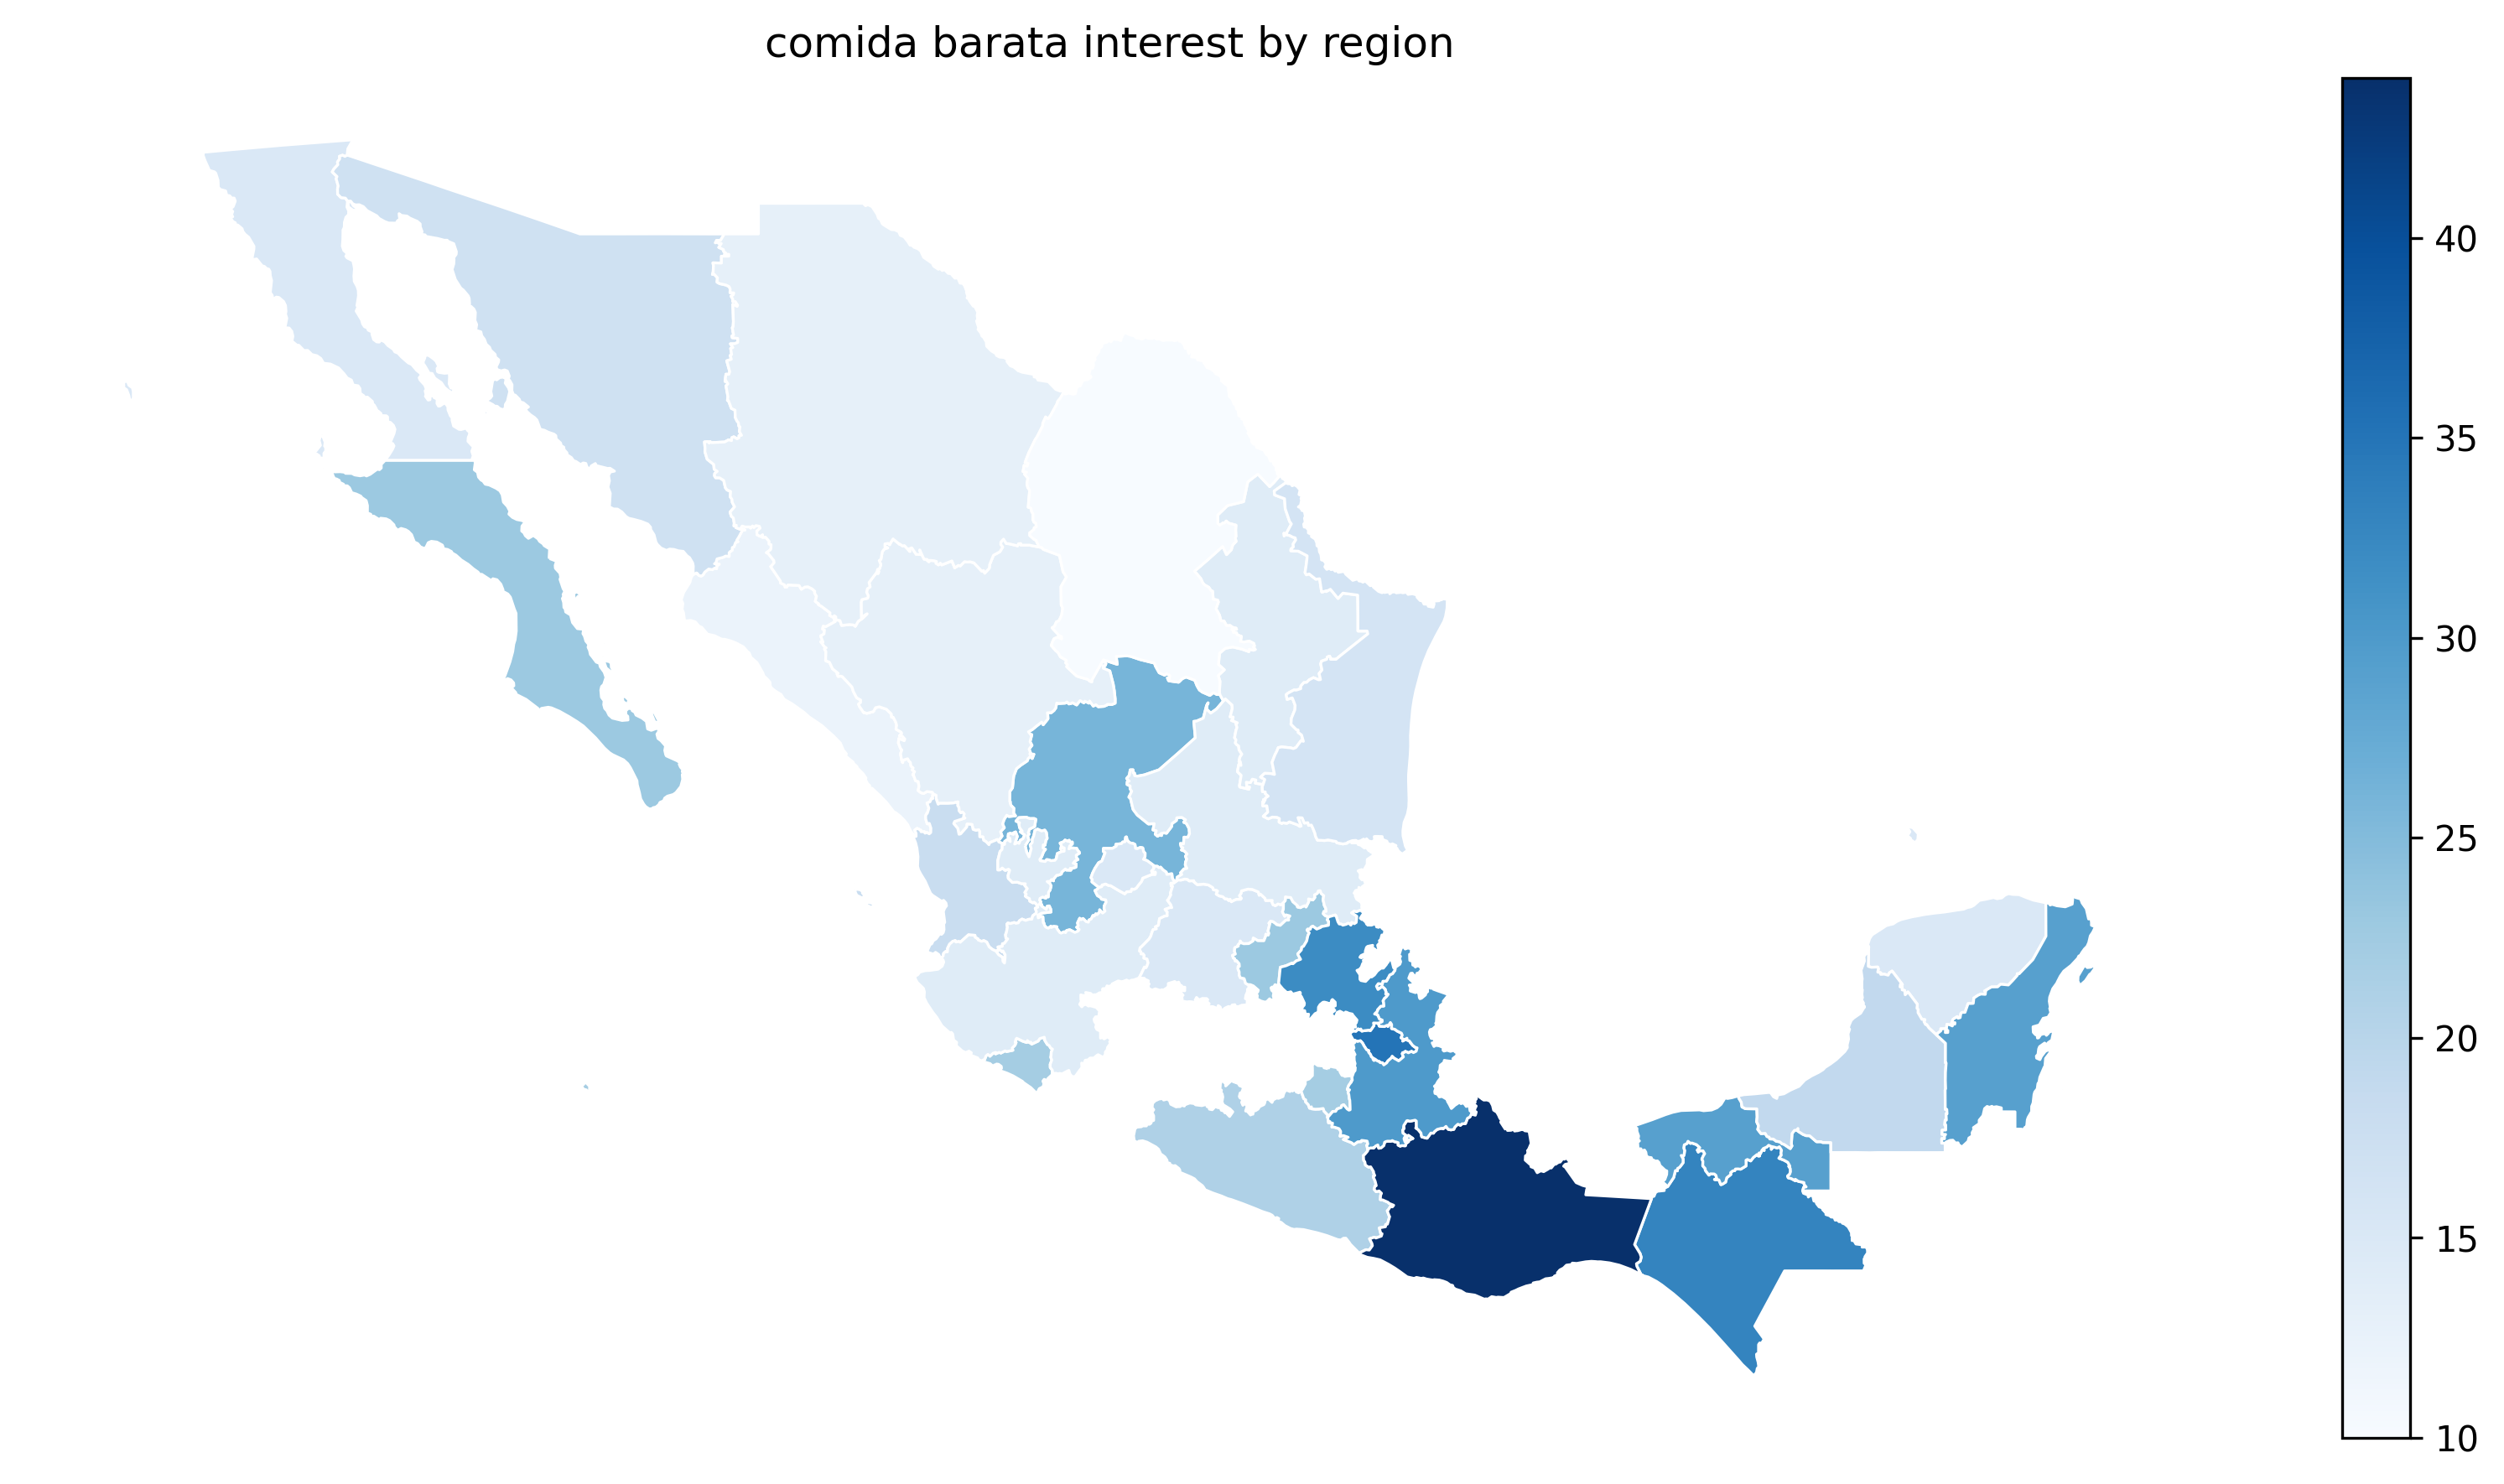

In [89]:
def plot_map(data: dict, keyword: str) -> None:
    rows = [
        {"region": r, "value": v}
        for r, v in data[keyword].items()
    ]
    data = pd.DataFrame(rows)

    mx_states_merged = mx_states.merge(
        data,
        left_on="state_name",
        right_on="region",
        how="left"
    )

    _, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=300)
    mx_states_merged.plot(
        column="value",
        cmap="Blues",
        linewidth=0.8,
        edgecolor="white",
        legend=True,
        ax=ax,
    )
    ax.set_axis_off()
    ax.set_title(f'{keyword} interest by region')
    plt.tight_layout()
    plt.show()

plot_map(geo_data, "comida barata")

In [90]:
def filter_timeseries_data(data: list) -> dict:
    result = {}

    for search in data:
        search_data = search["interest_over_time"]
        for timeline in search_data["timeline_data"]:
            timeline_values = timeline["values"]
            for timeline_value in timeline_values:
                if timeline_value["query"] not in result:
                    result[timeline_value["query"]] = []
                
                result[timeline_value["query"]].append({
                    "timestamp": timeline["timestamp"],
                    "value": timeline_value["extracted_value"]
                })

    return result

In [111]:
def plot_single_keyword(data: dict[str, list[dict]], keyword: str, state: str = None) -> None:
    df = pd.DataFrame(data[keyword])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")

    _, ax = plt.subplots(figsize=(12, 6))

    ax.plot(df["timestamp"], df["value"], marker='o', color="skyblue", linestyle='-', linewidth=2)
    ax.plot(df["timestamp"], df["value"].rolling(7).mean(), color="orange", linestyle='--', linewidth=1.5, label='7-day Rolling Avg')

    threshold = df["value"].quantile(0.9)
    for x, y in zip(df["timestamp"], df["value"]):
        if y >= threshold:
            ax.annotate(str(y), (x, y), textcoords="offset points", xytext=(0, 6), ha='center', fontsize=9)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=7))

    title = f"Time Series for '{keyword.capitalize()}'" if state is None else f"Time Series for '{keyword.capitalize()}' in {state}"
    ax.set_title(title, fontsize=16, weight='bold')
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Search Interest (0–100)", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='upper right')

    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b '%y"))
    ax.grid(True, which='major', linestyle='--', alpha=0.3)
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    ax.set_ylabel('Search Interest')
    ax.legend()

    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

In [92]:
def plot_all_keywords(timeseries_data: dict) -> None:
    plt.figure(figsize=(14, 7))

    for keyword, data in timeseries_data.items():
        df = pd.DataFrame(data)
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
        plt.plot(df["timestamp"], df["value"], marker='o', linestyle='-', label=keyword.capitalize())

    plt.title("Time Series for All Keywords", fontsize=16, weight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title="Keywords")
    plt.tight_layout()
    plt.show()

In [93]:
timeseries_data_states = {}

for index, keyword_set in enumerate(keywords):
    for state in STATES:
        gt_data = mongo_client.get_collection_entries(collection=f'serpapi_timeseries_{state}_{keyword_set}')[0]

        if state not in timeseries_data_states:
            timeseries_data_states[state] = {}

        timeseries_data_states[state][keyword_set] = gt_data

In [94]:
timeseries_data_states["MX-AGU"]["crisis,desempleo,pobreza,conflictos,discriminación"]

{'_id': ObjectId('6835d21793573604b2f63835'),
 'search_metadata': {'id': '6835d10e974bbb58d7a0ac6d',
  'status': 'Success',
  'json_endpoint': 'https://serpapi.com/searches/9cb6b21639396a0b/6835d10e974bbb58d7a0ac6d.json',
  'created_at': '2025-05-27 14:49:50 UTC',
  'processed_at': '2025-05-27 14:49:50 UTC',
  'google_trends_url': 'https://trends.google.com/trends/embed/explore/TIMESERIES?hl=es&tz=420&req=%7B%22comparisonItem%22%3A%5B%7B%22keyword%22%3A%22crisis%22%2C%22geo%22%3A%22MX-AGU%22%2C%22time%22%3A%22all%22%7D%2C%7B%22keyword%22%3A%22desempleo%22%2C%22geo%22%3A%22MX-AGU%22%2C%22time%22%3A%22all%22%7D%2C%7B%22keyword%22%3A%22pobreza%22%2C%22geo%22%3A%22MX-AGU%22%2C%22time%22%3A%22all%22%7D%2C%7B%22keyword%22%3A%22conflictos%22%2C%22geo%22%3A%22MX-AGU%22%2C%22time%22%3A%22all%22%7D%2C%7B%22keyword%22%3A%22discriminacio%CC%81n%22%2C%22geo%22%3A%22MX-AGU%22%2C%22time%22%3A%22all%22%7D%5D%2C%22category%22%3A0%2C%22property%22%3A%22%22%7D',
  'raw_html_file': 'https://serpapi.com/se

In [95]:
timeseries_data_states_result = {}

for state in STATES:
    for keyword_set in keywords:
        try:
            if state not in timeseries_data_states_result:
                timeseries_data_states_result[state] = {}
                
            timeseries_data_states_result[state][keyword_set] = filter_timeseries_data(
                [
                    timeseries_data_states[state][keyword_set]
                ]
            )
        except Exception as e:
            print(f'Error processing {state} for {keyword_set}: {e}')

Error processing MX-CAM for servicios en la vivienda,vivienda del gobierno: 'interest_over_time'
Error processing MX-DUR for servicios en la vivienda,vivienda del gobierno: 'interest_over_time'
Error processing MX-GRO for servicios en la vivienda,vivienda del gobierno: 'interest_over_time'
Error processing MX-NAY for servicios en la vivienda,vivienda del gobierno: 'interest_over_time'


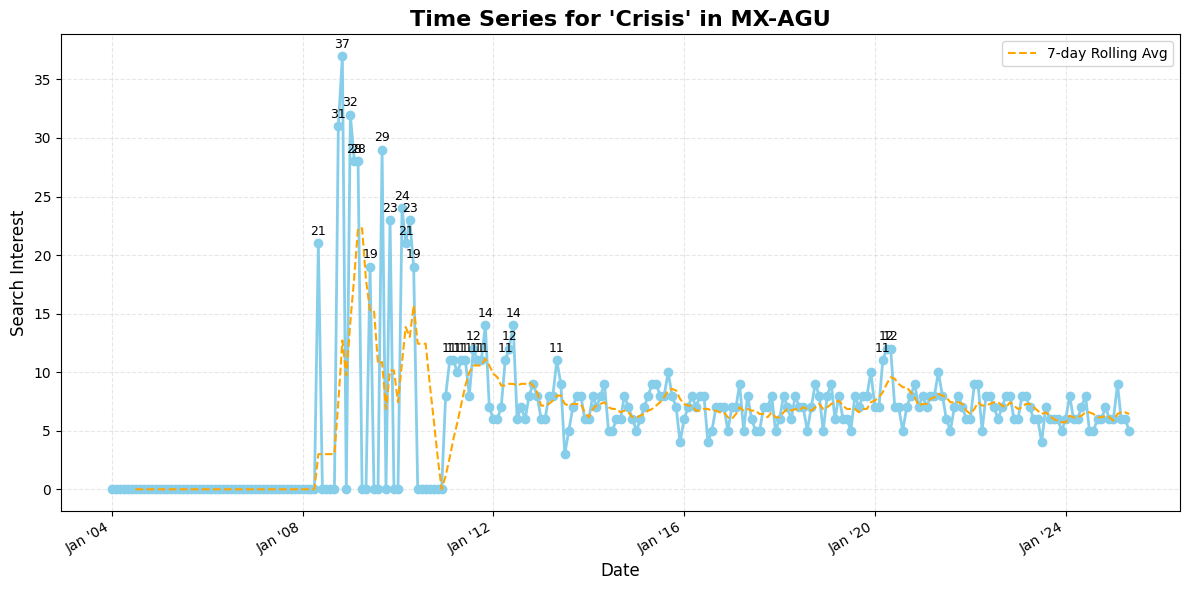

In [112]:
target_state = STATES[0]
target_keyword = keywords[0]

plot_single_keyword(timeseries_data_states_result[STATES[0]][target_keyword], "crisis", target_state)